# ADS Homework #4
Monday 2-5pm Session, Proffessor Tim Savage

Please submit this assignment to the NYU Classes 'Assignments' section by 12:00pm on Monday, November 12, strictly labeling the assignments with the format **'ADS_HW4_(your net ID).ipynb'**. Be sure not to confuse Net ID (e.g. 'acs882') with N-number ('N166...'). This homework is here for you to better understand and practice the material; while you may discuss approaches to problems with your classmates (in fact, this is encouraged!), please ensure that all final code submitted is your own. You may reach out to the TA, Alex Shannon, at acs882@nyu.edu at anytime (he hangs out at CUSP a lot (Thursdays are a particularly good day to find him), so feel free to say hello). Additionally, Professor Savage will hold office hours on Mondays from 9am-12am. While plots are initially rendered in this notebook to guide you, please ensure that your code can recreate them (or something very similar), as all notebooks will be run before grading.

### Problem 1 - Return on University Education (20 points)

Please read the following article: https://promarket.org/learning-university-pay-off/

Consider Judea Pearl's idea of the ladder of causality that was discussed in class.  Describe whether or not the study described in the article meets the standard of (a) association; (b) intervention; and (c) counterfactual.

**(a)** In the first paragraph of this article, the author introduced us the phenonmenon that the average wage of college graduates is 76% higher than high school graduates. Moreover, the average wage of Ivy League universities' graduates is twice that of other colleges. This is the association.

**(b)** There are two possible reasons for why students graduate from colleges, especially those top universities, are tend to earn more money. The first reason is what people learned in universities lead to higher wages, the second one is people who graduated from selective univerisities are smart, as a result, smart people make more money than ordinary ones. The course reform proved that keep the admission criteria remained the same, while students learn less from colleges, they are less paid. In other words, the first statement explained why top school graduates are well-paid. This is the intervention part in this article.

**(c)** There is no counterfactual analysis in the article, although students graduated from Los Andes after the reformation of class are less likely to receive the offer from Central Bank, it is not comprehensive enough to prove that the reformation caused the decreasement of employment.

### Problem 2 - Markov Processes (40 points)

In class, we walked through an example of a rat moving between subway tracks. While any New Yorker knows that this is doubtlessly a very real urban example, in the real world, unless you have an oddly musophilic boss, you likely will be tasked with more human-centric analyses. Let's dig into an example of people moving throughout a subset of 5 Brooklyn Neighborhoods. 
<br><br>
Assumptions made here are that total population is static (i.e. no new entrants or people moving outside of this subset of neighborhoods), and that there's a 40% chance that people stay in their current neighborhood (which can be interpreted as either not moving or moving very close by) and a known probability of moving from one neighborhood to another (these are defined in the code below), with preference shown for bordering neighborhoods. 
<br><br>
We will load geo-data and filter to the specified Brooklyn neighborhoods. We will then examine movement between neighborhoods as a Markov Process, iterating until an equilibrium becomes apparent (hint: you should not see any absorbing states in this example), then visualize and interpret the results.

**Part 1**: Go through the below example, completing the code where marked. (30 points)

In [1]:
import imageio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import time
from IPython.display import HTML
from geopandas import GeoDataFrame
%matplotlib inline
sns.set_style('white')

In [2]:

# filters to apply to the data
county = 'Kings'
hoods  = ['Downtown', 'DUMBO', 'Fort Greene', 'Boerum Hill', 'Clinton Hill']

def get_neighborhoods(file, county=county, neighborhoods=hoods):
    '''
    reads in geopandas file from Zillow, returns geodataframe with specified neighborhoods
    '''
    # read in the geodata file ('file') and consolidate to the 5 selected neighborhoods (listed above)
    
    #####your code here#####
    ny = GeoDataFrame.from_file('ZillowNeighborhoodsNY.shp')
    ny_gdf = ny.loc[(ny['County']==county)&(ny['Name'].isin(hoods))]
    # locate coordinate points to plot neighborhood names
    ny_gdf['coords'] = ny_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    ny_gdf['coords'] = [coords[0] for coords in ny_gdf['coords']]
    return ny_gdf

bk_neighborhoods = get_neighborhoods('ZillowNeighborhoodsNY.shp',county=county,neighborhoods=hoods)
bk_neighborhoods = bk_neighborhoods.sort_values('Name').reset_index(drop=True)
bk_neighborhoods

/Users/hemingyi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/hemingyi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,State,County,City,Name,RegionID,geometry,coords
0,NY,Kings,New York,Boerum Hill,272994,POLYGON ((-73.98682489707035 40.68846655576456...,"(-73.9864896425407, 40.68600290969882)"
1,NY,Kings,New York,Clinton Hill,270815,"POLYGON ((-73.9619257224787 40.69778778197278,...","(-73.96455445229091, 40.689058350724)"
2,NY,Kings,New York,DUMBO,270841,POLYGON ((-73.98446723099994 40.70646091900005...,"(-73.99003960915954, 40.703545669500045)"
3,NY,Kings,New York,Downtown,270825,POLYGON ((-73.98697203810939 40.70105040762233...,"(-73.98678098579373, 40.693458468711725)"
4,NY,Kings,New York,Fort Greene,273766,POLYGON ((-73.98230754099966 40.70227250100029...,"(-73.97573066517539, 40.69136863239475)"


Above we can see the geodataframe. Now let's plot it: 

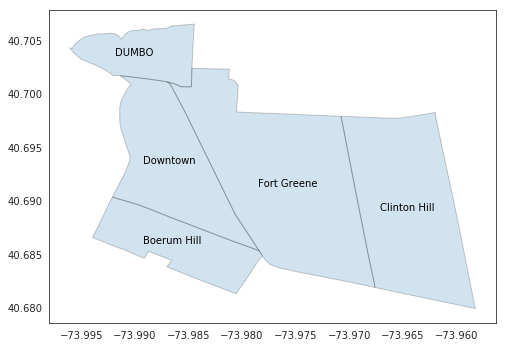

In [3]:
bk_neighborhoods.plot(figsize=(8, 6), edgecolor='black', alpha=0.2)

for idx, row in bk_neighborhoods.iterrows():
    plt.annotate(s=row['Name'], xy=row['coords'], color='Black', horizontalalignment='center', size=10)

Here, we define the likelihoods of moving from one neighborhood to another.
Use a Dirichlet Distrobution (convenient for generating samples that sum to 1.0) to obtain an initial starting population for the neighborhoods https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.dirichlet.html

In [4]:
np.random.seed(42)
data = np.random.dirichlet((1,1,1,1,1), 1)
#####your code here##### # use a dirichlet distribution to create a 1-by-5 matrix of values that sum to 1.0 
initial_vals = zip(list(bk_neighborhoods.Name), np.array(data)[0])
print('Initial allocations:')
print('--------------------')
for i, j in initial_vals:
    print('{:<13s} {:>5.2f}%'.format(i, round(j, 4)*100))
print('--------------------')
print()

move_likelihoods = np.matrix('0.4 0.1 0.1 0.2 0.2; 0.1 0.4 0.1 0.15 0.25; 0.1 0.1 0.4 0.2 0.2;' 
                             + '0.2 0.05 0.15 0.4 0.2; 0.15 0.2 0.05 0.2 0.4')
pd.DataFrame(data=move_likelihoods, index=bk_neighborhoods.Name, columns=bk_neighborhoods.Name) 
# we could use 'tabulate' here, as this is for visualization purposes, but a pd dataframe is 
# often just as clear and has more compatability with python environments

Initial allocations:
--------------------
Boerum Hill    7.98%
Clinton Hill  51.20%
DUMBO         22.40%
Downtown      15.53%
Fort Greene    2.89%
--------------------



Name,Boerum Hill,Clinton Hill,DUMBO,Downtown,Fort Greene
Name,,,,,
Boerum Hill,0.40,0.10,0.10,0.20,0.20
Clinton Hill,0.10,0.40,0.10,0.15,0.25
DUMBO,0.10,0.10,0.40,0.20,0.20
Downtown,0.20,0.05,0.15,0.40,0.20
Fort Greene,0.15,0.20,0.05,0.20,0.40


Here we will build a Markov process and visualize it in a GIF; this is useful for seeing equilibrium state reached over time. We will then look at the numbers to confirm what the plot is showing us. 

In [5]:
years = 7
pct_by_year = []

def plot_neighborhood_movement(years):

    pct_in_hood = np.matrix(data)*np.linalg.matrix_power(move_likelihoods, years)
#     print(pct_in_hood)
    #####your code here##### # use the matrix_power function to run a step in the markov process
    bk_neighborhoods['pct_in_hood'] = np.array(pct_in_hood)[0]
    pct_by_year.append(np.array(pct_in_hood)[0])
    vmin, vmax = bk_neighborhoods['pct_in_hood'].min(), bk_neighborhoods['pct_in_hood'].max()

    fig, ax = plt.subplots(figsize=(8,6))
    base = bk_neighborhoods.plot(ax=ax, column='pct_in_hood', edgecolor='grey', 
                                cmap='Blues', vmin=vmin, vmax=vmax, legend=False)

    plt.title('Year:{}'.format(years), size=16)
    
    for idx, row in bk_neighborhoods.iterrows():
        #####your code here##### # put neighborhood names on the plot in red font
        plt.annotate(s=row['Name'], xy=row['coords'], color='Red', horizontalalignment='center')
        
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('neighborhood_movement.gif', [plot_neighborhood_movement(year) for year in range(years)], fps=1)

HTML('<img src="neighborhood_movement.gif">')

In [6]:
pd.DataFrame(data=np.matrix(pct_by_year), columns=bk_neighborhoods.Name, 
             index=['Year {}'.format(i) for i in range(len(np.matrix(pct_by_year)))]).style.format("{:.1%}")

Name,Boerum Hill,Clinton Hill,DUMBO,Downtown,Fort Greene
Year 0,8.0%,51.2%,22.4%,15.5%,2.9%
Year 1,14.1%,24.9%,17.4%,20.5%,23.1%
Year 2,17.4%,18.7%,15.1%,22.9%,25.9%
Year 3,18.8%,17.1%,14.4%,23.6%,26.1%
Year 4,19.3%,16.5%,14.2%,23.9%,26.1%
Year 5,19.5%,16.4%,14.1%,23.9%,26.0%
Year 6,19.5%,16.3%,14.1%,24.0%,26.0%


**Part 2**: Interpret the results - what trends do we notice towards the end of the GIF? Why might this be? What would we expect if we ran this over 100 iterations (feel free to try this)? (10 points)

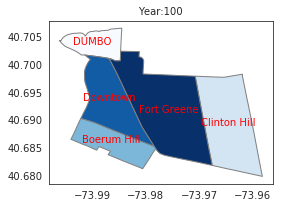

In [7]:
def plot_neighborhood_status(years):

    pct_in_hood = np.matrix(data)*np.linalg.matrix_power(move_likelihoods, years)
#     print(pct_in_hood)
    #####your code here##### # use the matrix_power function to run a step in the markov process
    bk_neighborhoods['pct_in_hood'] = np.array(pct_in_hood)[0]
    
#     pct_by_year.append(np.array(pct_in_hood)[0])
    vmin, vmax = bk_neighborhoods['pct_in_hood'].min(), bk_neighborhoods['pct_in_hood'].max()

    fig, ax = plt.subplots(figsize=(4,3))
    base = bk_neighborhoods.plot(ax=ax, column='pct_in_hood', edgecolor='grey', 
                                cmap='Blues', vmin=vmin, vmax=vmax, legend=False)

    plt.title('Year:{}'.format(years), size=10)
    
    for idx, row in bk_neighborhoods.iterrows():
        #####your code here##### # put neighborhood names on the plot in red font
        plt.annotate(s=row['Name'], xy=row['coords'], color='Red', horizontalalignment='center')

plot_neighborhood_status(100)

From the gif, we can tell that at the begining, Clinton Hill had the most population. However, with the movement, Fort Greene and Downtown contain the most people, Clinton Hill and DUMBO have the fewest people. In the process, the population in Clinton Hill is decreasing, and in Downtown, Fort Greene and Boerum Hill is growing. It might caused by the movement liklihood. No matter where are people currently live in, the possibility of moving to Fort Greene or Downtown is always higher than the rest neiborhoods. As for each neiborhood, the possibility of moving out of there is 60%; for a certain neiborhood, if we sum the other neibohoods' possiblity of moving the this one and find the value is lower than 60%, this neibohoods' population is decreasing. Eventually, most people will stay in Fort Greene or Downtown. Keep the liklihood of movement the same, 100 years later, Fort Greene has the highest population value.

This is some pretty cool stuff! If you had enough data, you could theoretically do this for all of NYC (you'd additionally have to factor in people moving into and out of the city, but that's not too hard. Further, you might change the percentages over time (e.g. when the L-train shuts down, you may want to lower the % of people moving to Williamsburg in your model - all sorts of cool things you can do!). 

### Problem 2 - Time Series (40 points)

This dataset looks at measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years; the data is initially messy, and will take a lot of cleaning. You will find that there is some correlation between the data (i.e. what we know about the current state can tell us something about the future state), and you will then construct an Autoregressive Model to predict future values.

Source: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

Variable Descriptions:
1. date: Date in format dd/mm/yyyy <br> 
2. time: time in format hh:mm:ss <br>
3. global_active_power: household global minute-averaged active power (in kilowatt) <br>
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt) <br>

In [3]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from zipfile import ZipFile
sns.set_style('darkgrid')
%matplotlib inline

In [4]:
zip_result = ZipFile('household_power_consumption.zip','r')
zip_result.extractall()

cols = ['Date', 'Global_active_power', 'Global_reactive_power']
test = pd.read_csv('household_power_consumption.txt', sep=';', nrows=10,engine='python')
sample = test[::2000]

**Part 1**: Read in the data. It is in a .txt file, but you can read it in with 'pd.read_csv()' - you may want to consider the  'sep', 'parse_dates', 'usecols', 'infer_datetime_format', 'keep_default_na', 'skip_blank_lines', 'skiprows', and 'dtype' arguements in the function. You also may want to use the 'nrows' arguement or use a limited version of the dataset as you adjust these, as it is a large one. Finally, you may need to read in the dataset more than once if you want to use the 'dtype' arguement to create floating-points (hint: the 'skiprows' arguement may need a +1 to work as expected). (15 points)

In [5]:
cols = ['Date', 'Global_active_power', 'Global_reactive_power']

pwr_consumption = pd.read_csv('household_power_consumption.txt',sep=';',
                              usecols=cols,parse_dates=['Date'],infer_datetime_format=True,skip_blank_lines=True)#####your code here#####)

pwr_consumption = pwr_consumption.convert_objects(convert_numeric=True)

pwr_consumption = pwr_consumption.groupby(['Date'])['Global_active_power', 'Global_reactive_power'].sum()
#####your code here##### # group the newly-cleaned data by date, using the .sum() function to aggregate


/Users/hemingyi/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/hemingyi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


**Part 2**: Plot the data. Use the lag_plot() function to examine the correlation. Describe your findings. (10 points)

In [6]:
pwr_consumption = pwr_consumption[pwr_consumption['Global_reactive_power']!=0]

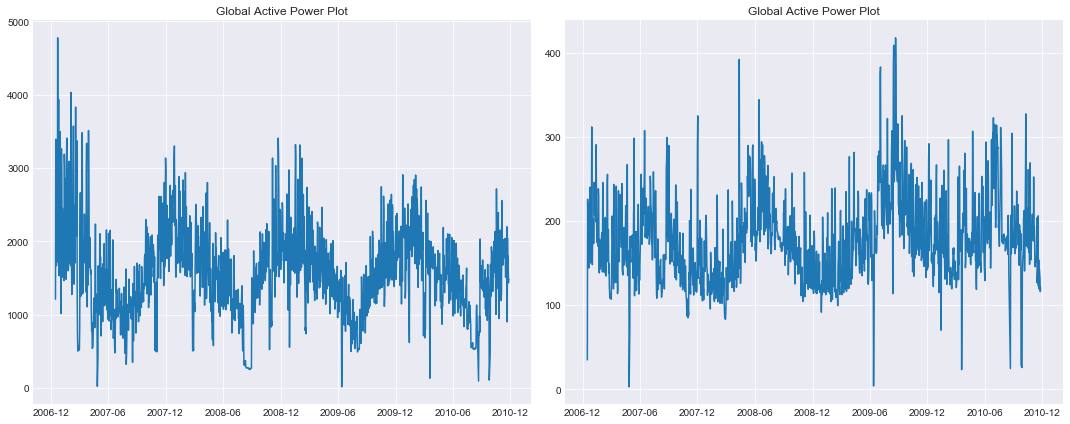

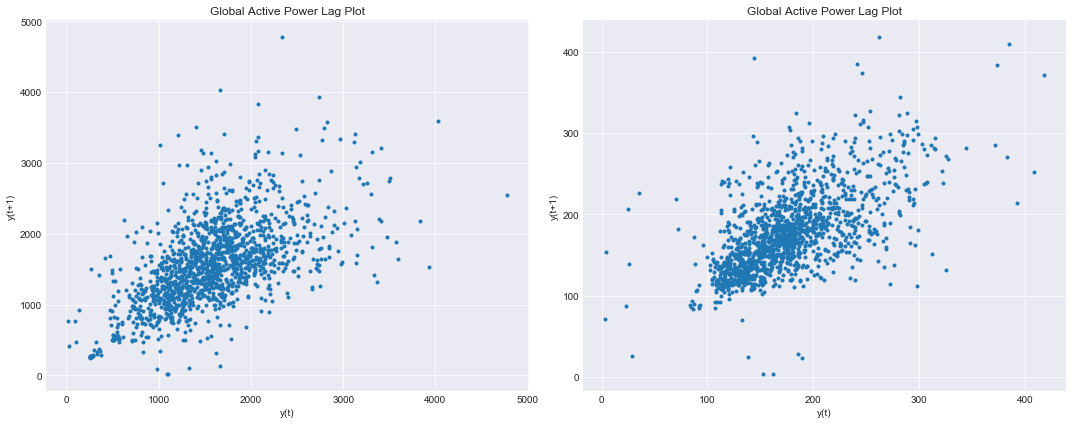

In [12]:
glb_active_pwr   = pwr_consumption[['Global_active_power']]#####your code here#####
glb_reactive_pwr = pwr_consumption[['Global_reactive_power']]#####your code here#####
glb_active_pwr['lag'] = glb_active_pwr.Global_active_power.shift(1)
glb_reactive_pwr['lag'] = glb_reactive_pwr.Global_reactive_power.shift(1)
glb_active_pwr['lag_23'] = glb_active_pwr.Global_active_power.shift(23)
glb_reactive_pwr['lag_23'] = glb_reactive_pwr.Global_reactive_power.shift(23)
glb_active_pwr.fillna(0)
glb_reactive_pwr.fillna(0)
glb_active_pwr.name = 'Global Active Power'
glb_reactive_pwr.name = 'Global Active Power'
def time_series_plotting(func,series1, series2):
    """
    takes time series data and plots, based on a give function
    """
    fig, ax = plt.subplots(2, figsize=(15,6))


    if func == 'plot':
        plt.subplot(121)
        plt.plot(series1.index, series1.Global_active_power)    
        plt.title('{} {}'.format(series1.name, func).replace('_', ' ').title())

        plt.subplot(122)
        plt.plot(series2.index, series2.Global_reactive_power)    
        plt.title('{} {}'.format(series2.name, func).replace('_', ' ').title())
    elif func == 'lag_plot':
        plt.subplot(121)
        plt.plot( series1.lag,series1.Global_active_power,'.')    
        plt.title('{} {}'.format(series1.name, func).replace('_', ' ').title())
        plt.xlabel('y(t)')
        plt.ylabel('y(t+1)')
        
        plt.subplot(122)
        plt.plot( series2.lag,series2.Global_reactive_power,'.')
        plt.title('{} {}'.format(series2.name, func).replace('_', ' ').title())
        plt.xlabel('y(t)')
        plt.ylabel('y(t+1)')
    plt.tight_layout()
    plt.show()

time_series_plotting('plot',glb_active_pwr, glb_reactive_pwr)
time_series_plotting('lag_plot', glb_active_pwr, glb_reactive_pwr)

We cannot find a significant tendency from the first two plots, but from the later two plot, it is obvious that the value of y<sub>t-1</sub> and y<sub>t</sub> is correlated.

**Part 3**: Fit an autoregressive model to the data, and use it to make predictions over the next 30 days of useage (defined by creating a test set from the last 30 days of available data). Describe your findings. (15 points)

In [8]:
glb_active_pwr = pd.Series(glb_active_pwr['Global_active_power'], index = glb_active_pwr.index)
glb_reactive_pwr = pd.Series(glb_reactive_pwr['Global_reactive_power'], index = glb_reactive_pwr.index)

Global_active_power
Lag: 23
Test_Active MSE: 131091.374

Global_reactive_power
Lag: 23
Test_Active MSE: 1397.127


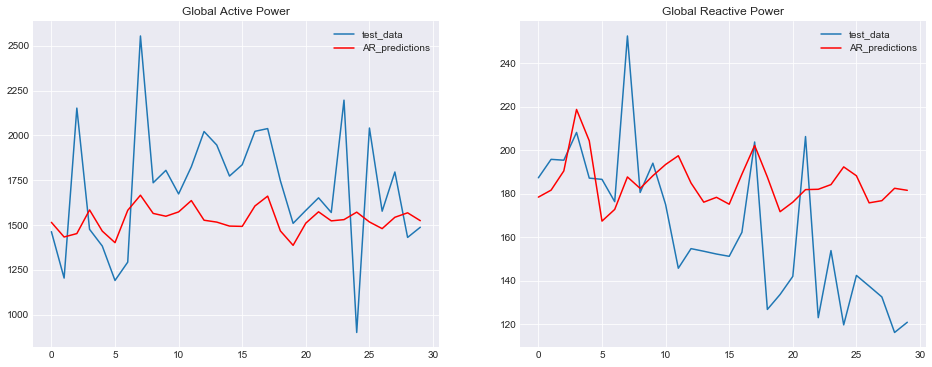

In [9]:
def fit_AR1(series):
    vals = series.values
    train, test = vals[1:len(vals)-30], vals[len(vals)-30:]

    model = AR(train)
    model_fit = model.fit()
    print(series.name)
    print('Lag: %s' % model_fit.k_ar)
    predictions = model_fit.predict(start=len(train), end=len(vals)-2, dynamic=False)
    
#     for i in range(len(predictions)):
    error = mean_squared_error(test, predictions)
    print('Test_Active MSE: %.3f' % error)
    return test, predictions

t1, p1 = fit_AR1(glb_active_pwr)
print()
t2, p2 = fit_AR1(glb_reactive_pwr)

fig, ax = plt.subplots(2, figsize=(16,6))

plt.subplot(121)
plt.plot(t1, label='test_data')
plt.plot(p1, color='red', label='AR_predictions')
plt.title('Global Active Power')
plt.legend()

plt.subplot(122)
plt.plot(t2, label='test_data')
plt.plot(p2, color='red', label='AR_predictions')
plt.title('Global Reactive Power')
plt.legend()

plt.show()

From the latter two plots, we can tell that the AR_predictions results didn't predict the real value accurately in both Global Active Power and Global Reactive Power. The model can roughly predict the value's tendency, which means in most places, the model is able to predict the value is increasing or decreasing. The real data' fluctuation is much strhonger than the predicted values, in other words, the model failed to predict those dramatic changes.